## Distributed lag model

$$
y_{t}=a+w_{0}x_{t}+w_{1}x_{t-1}+w_{2}x_{t-2}+...+{\text{error term}}
$$

https://en.wikipedia.org/wiki/Distributed_lag

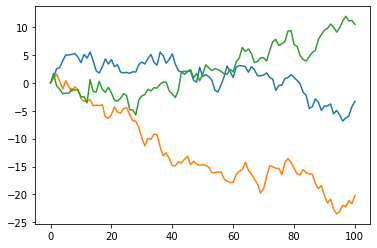

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
time = np.arange(N+1)
dt = 1
d = 3

x_diff = np.random.normal(size = [N,d]) * np.sqrt(dt)
x = np.cumsum(x_diff,axis = 0)
x = np.concatenate([np.zeros([1,d]), x], axis = 0)

# x1 = 0.5 * np.sqrt(time)[:,None]
# x2 = np.sin(time)[:,None]
# x3 = np.log(time+1)[:,None]
# x = np.concatenate([x1,x2,x3], axis = 1)

plt.plot(time,x)
plt.show()

In [3]:
def lag(x,length,gap):
    x = x[:,None,:]
    X = x[:1-length-gap]
    for i in range(1,length):
        helper = x[i:1-length-gap+i]
        X = np.concatenate([X, helper], axis = 1)
    return X
x_lag = lag(x,3,1)
len_lag = x_lag.shape[0]

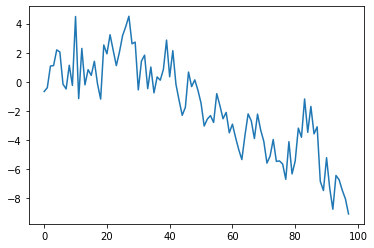

In [4]:
import torch
import torch.nn as nn
x_lag_flatten = torch.tensor(x_lag, dtype = torch.float).view([len_lag,-1])
linear = nn.Linear(x_lag_flatten.shape[-1],1)
y = linear(x_lag_flatten)
y = y.detach().numpy() + np.random.normal(size = [len_lag,1])
plt.plot(y)
plt.show()

In [5]:
import sklearn
split = 60
num_sample = x_lag.shape[0]
X = np.reshape(x_lag,[num_sample,-1])
y = y
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [6]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)
y_predict = np.concatenate([y_train_predict,y_test_predict],axis = 0)

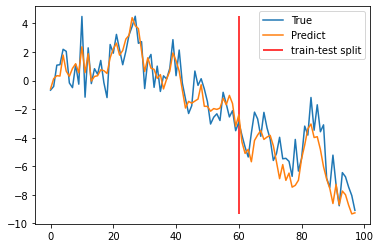

In [7]:
plt.plot(y)
plt.plot(y_predict)
lmax = max(y.max(),y_predict.max())
lmin = min(y.min(),y_predict.min())
plt.vlines(split,lmin,lmax,'r')
plt.legend(['True', 'Predict', 'train-test split'])
plt.show()

In [83]:
def lag(x,length,gap):
    x = x[:,None,:]
    X = x[:1-length-gap]
    for i in range(1,length):
        helper = x[i:1-length-gap+i]
        X = np.concatenate([X, helper], axis = 1)
    return X

## Real Data

$$
d_{t} = f(c_{t-1}, c_{t-2}, c_{t-3}) + noise
$$
where $d$ is death and $c$ is new cases

In [177]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [178]:
df = pd.read_csv("data/1_owid/owid-covid-data.csv")
df_europe = df[df['continent'] == 'Europe']
df0 = df_europe
df0 = df0[['date',\
           'location',\
       'new_cases_smoothed_per_million',\
       'new_deaths_smoothed_per_million',\
       'icu_patients_per_million']]
#        'positive_rate']]
df0 =df0.dropna()
df00 = df0

C = list(df0['location'].drop_duplicates())
df00 = df0.drop(columns=['date','location'])
x = df00.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df00 = pd.DataFrame(x_scaled, index = df00.index, columns=df00.columns)


In [179]:
df_helper = df_europe[['location', 'population','population_density']]
POPULATION = []
POPULATION_DENSITY = []
for c in C:
    population = df_helper[df_helper['location'] == c].iloc[0]['population']
    density = df_helper[df_helper['location'] == c].iloc[0]['population_density']
    POPULATION.append(population)
    POPULATION_DENSITY.append(density)

In [181]:
import string
from matplotlib import cm

def plot_scatter_helper(name_x, name_y, x, y):
    df_helper = pd.DataFrame({name_x:x, name_y:y}, 
                      index=C)
    fig, ax = plt.subplots(figsize = [12,4])


    cmap = cm.get_cmap('Spectral')
    df_helper.plot(name_x, name_y, kind='scatter', ax=ax, s=100, linewidth=0, 
            c=range(len(df_helper)), colormap=cmap)

    for k, v in df_helper.iterrows():
        ax.annotate(k, v,
                    xytext=(10,-5), textcoords='offset points',
                    family='sans-serif', fontsize=10, color='darkslategrey')
    fig.canvas.draw()

Austria
train 0.8713886905300795
test 0.08428892693968659


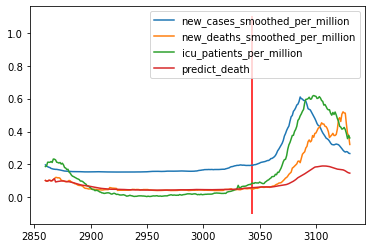

Belgium
train 0.8119138012750021
test 0.39229553608553414


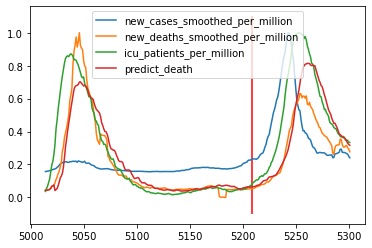

Cyprus
train 0.311193093473886
test 0.037136942488280034


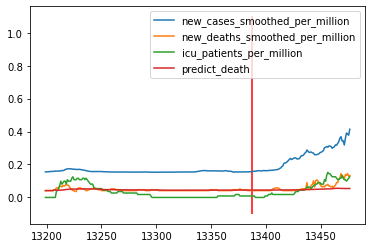

Czechia
train 0.3924384152269713
test -1.764506923186647


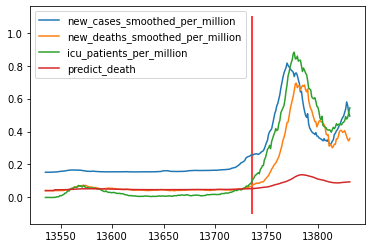

Denmark
train 0.7010012499968872
test 0.6914315172450185


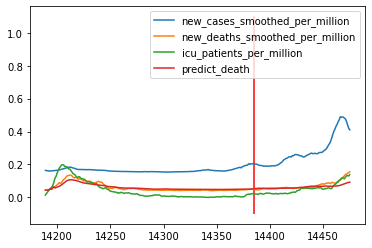

Estonia
train 0.3678884727543861
test 0.5072772496182598


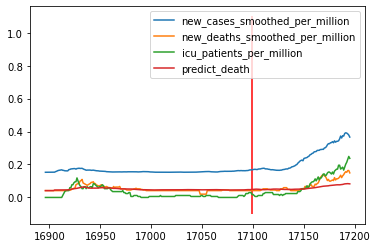

Finland
train 0.2678054114220725
test -3.2707773277669077


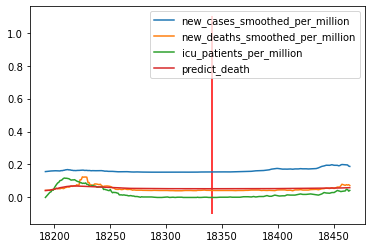

France
train 0.917560265069698
test 0.7846622954592013


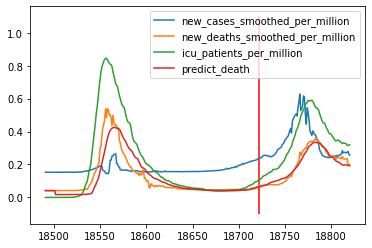

Germany
train 0.9382186897230649
test 0.7572969851321091


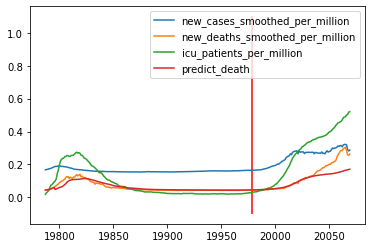

Iceland
train 0.5848543425549978
test -0.06756377530400304


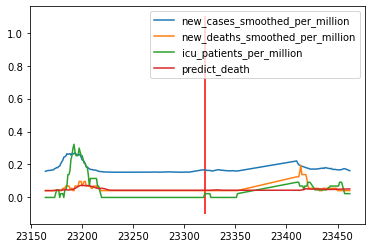

Ireland
train 0.5826912811594012
test -17.154552354592624


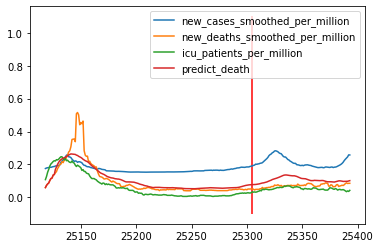

Italy
train 0.9520322906960563
test 0.8741455038735593


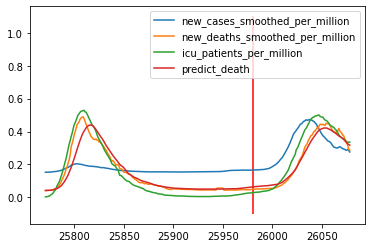

Luxembourg
train 0.8341239229522187
test 0.46992962089056256


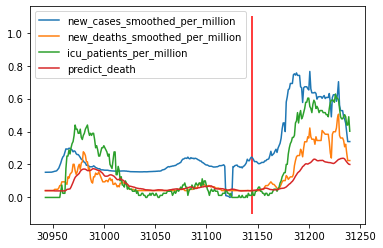

Malta
train 0.02533755248452252
test -0.014065058023893684


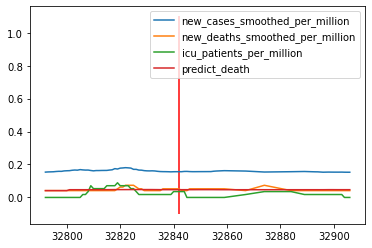

Netherlands
train 0.9168378155347888
test 0.8251047265454609


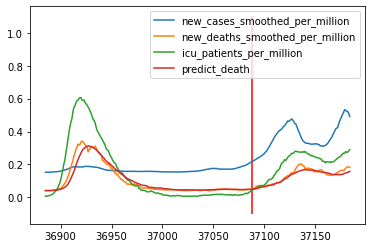

Portugal
train 0.760887114068137
test 0.5925759855646333


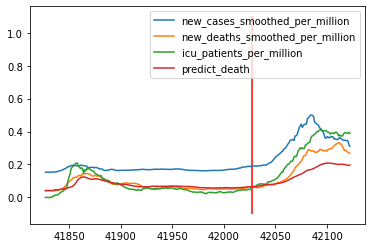

Romania
train 0.8749200797443643
test -0.22202343356883247


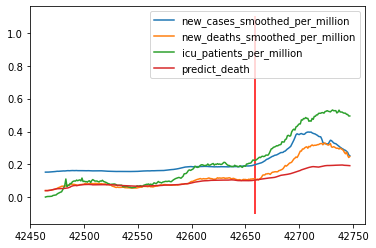

Slovenia
train 0.6185700040359564
test -0.5014881645705622


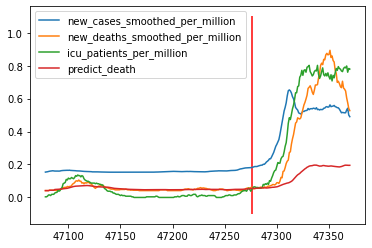

Spain
train 0.6811213457692518
test -1.931781447914148


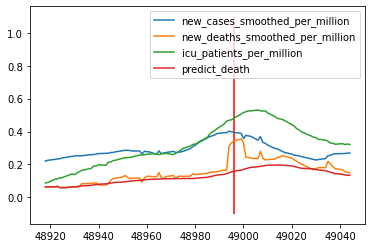

Sweden
train 0.9763161444890358
test 0.7441068067026049


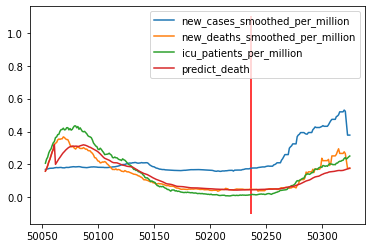

United Kingdom
train 0.9633585911178535
test 0.8111990830621727


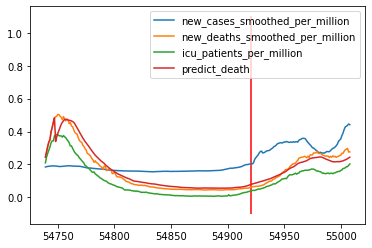

In [147]:
TRAIN = []
TEST = []
C_table = []
for c in C:
    print(c)
    
    cc = df00[df0['location'] == c]
    C_table.append(cc)
    x = cc[['new_cases_smoothed_per_million', 'icu_patients_per_million']].values
    y = cc['new_deaths_smoothed_per_million'].values
    length = 5
    gap = 5
    x_lag = lag(x,length,gap)
    y_lag = y[:len(x_lag),None]
    
    num_sample = x_lag.shape[0]
    split = int(0.7*num_sample)
    X = np.reshape(x_lag,[num_sample,-1])
    Y = y_lag
    X_train = X[:split]
    Y_train = Y[:split]
    X_test = X[split:]
    Y_test = Y[split:]
    
    model = Ridge(alpha=1)
    model.fit(X_train, Y_train)
    
    print('train', model.score(X_train,Y_train))
    print('test', model.score(X_test,Y_test))
    TRAIN.append(model.score(X_train,Y_train))
    TEST.append(model.score(X_test,Y_test))
    
    Y_train_predict = model.predict(X_train)
    Y_test_predict = model.predict(X_test)
    Y_predict = np.concatenate([Y_train_predict,Y_test_predict],axis = 0)
    Y_predict_aug = np.concatenate([Y[:length+gap-1,:],Y_predict],axis = 0)
    
    cc = cc.assign(predict_death=pd.Series(Y_predict_aug[:,0]).values)
    cc.plot()
    
#     plt.plot(Y)
#     plt.plot(Y_predict)
#     lmax = max(y.max(),Y_predict.max())
#     lmin = min(y.min(),Y_predict.min())
    plt.vlines(cc.index[split],-0.1,1.1,'r')
#     plt.legend(['True', 'Predict', 'train-test split'])
    plt.show()
    

test score


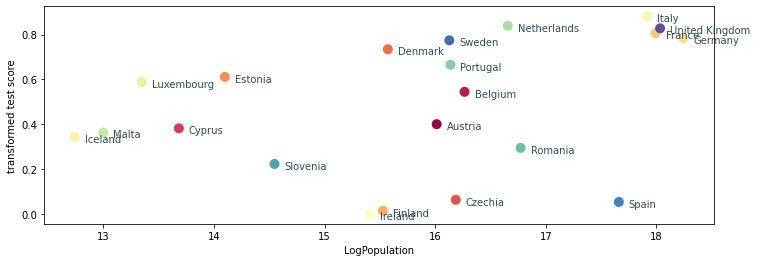

In [185]:
name_x = 'LogPopulation'
name_y = 'transformed test score'
x = np.log(np.array(POPULATION))
y = np.exp(np.array(TEST)-1)
print('test score')
plot_scatter_helper(name_x, name_y, x, y)

train score


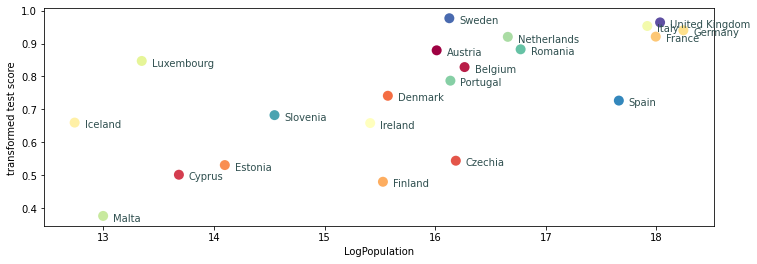

In [184]:
name_x = 'LogPopulation'
name_y = 'transformed test score'
x = np.log(np.array(POPULATION))
y = np.exp(np.array(TRAIN)-1)
print('train score')
plot_scatter_helper(name_x, name_y, x, y)

In [ ]:
C_large = []
POPULATION_large = []
choose_large = []
for c,p in zip(C,POPULATION):
    if p > 10**7:
        C_large.append(c)
        POPULATION_large.append(p)

In [50]:
# df2 = pd.read_csv("data/2_ecdc/notification.csv")
# df2 = pd.read_csv("data/2_ecdc/dailynotificationeu.csv")
# df2 = pd.read_csv("data/2_ecdc/weeklynotificationeu.csv")
# df2 = pd.read_csv("data/2_ecdc/admissionrates.csv")
df2 = pd.read_csv("data/2_ecdc/country_response_measures.csv")
# df2 = pd.read_csv("data/2_ecdc/agerangenotificationeu.csv")
df2

Country       Response_measure  date_start    date_end
0            Austria  AdaptationOfWorkplace  2020-03-10         NaN
1            Austria         BanOnAllEvents  2020-11-03         NaN
2            Austria            ClosDaycare  2020-03-16  2020-05-04
3            Austria     ClosDaycarePartial  2020-11-17  2020-12-07
4            Austria               ClosHigh  2020-03-16  2020-09-30
...              ...                    ...         ...         ...
1334  United Kingdom   StayHomeOrderPartial  2020-05-10  2020-07-04
1335  United Kingdom          StayHomeRiskG  2020-03-16  2020-07-05
1336  United Kingdom          StayHomeRiskG  2020-11-05  2020-12-01
1337  United Kingdom   StayHomeRiskGPartial  2020-07-06  2020-08-01
1338  United Kingdom            Teleworking  2020-03-16         NaN

[1339 rows x 4 columns]